# 4.0 ETL (Data Cleaning and Integration)
This section describes the Extract, Transform, and Load (ETL) process used to prepare the air quality and meteorological datasets for integrated analysis and modelling.
It will also handle the second research objective: Clustering Weather Regimes and Air Quality Risk Indicators.

### 4.1 Data Harmonisation
Before merging, both datasets are harmonised to ensure consistency in temporal resolution, variable naming, and data types.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import os

In [2]:
weather_df = pd.read_csv("../datasets/weather_df.csv")
aq_df = pd.read_csv("../datasets/air_quality_df.csv")

In [3]:
# load weather variables data
weather_df.dtypes

date                     object
temperature_2m          float64
relative_humidity_2m    float64
precipitation           float64
wind_speed_10m          float64
surface_pressure        float64
city                     object
country                  object
lat                     float64
lon                     float64
dtype: object

In [4]:
aq_df.dtypes

date                 object
pm10                float64
pm2_5               float64
carbon_monoxide     float64
sulphur_dioxide     float64
ozone               float64
us_aqi              float64
carbon_dioxide      float64
nitrogen_dioxide    float64
city                 object
country              object
lat                 float64
lon                 float64
dtype: object

### 4.1.1 Clean & Prepare Each Dataset
- a) Weather forecast variables dataset

In [5]:
# Weather dataset
weather_df['date'] = pd.to_datetime(weather_df['date']) # change to datetime
weather_df['date_day'] = weather_df['date'].dt.date # create new column date_day
weather_df['hour'] = weather_df['date'].dt.hour #create new column hour

weather_df.head(3)


,date,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,surface_pressure,city,country,lat,lon,date_day,hour
0,2025-11-07 00:00:00+00:00,18.7575,77.0,0.0,6.696387,1006.03955,Los Angeles,US,34.0522,-118.2437,2025-11-07,0
1,2025-11-07 01:00:00+00:00,17.6075,84.0,0.0,5.116561,1006.09620,Los Angeles,US,34.0522,-118.2437,2025-11-07,1
2,2025-11-07 02:00:00+00:00,16.7575,89.0,0.0,2.811690,1005.86676,Los Angeles,US,34.0522,-118.2437,2025-11-07,2


- b) Air quality variables

In [6]:
# Air quality dataset 
aq_df['date'] = pd.to_datetime(aq_df['date'])
aq_df['date_day'] = aq_df['date'].dt.date
aq_df['hour'] = aq_df['date'].dt.hour
aq_df.head(2)


,date,pm10,pm2_5,carbon_monoxide,sulphur_dioxide,ozone,us_aqi,carbon_dioxide,nitrogen_dioxide,city,country,lat,lon,date_day,hour
0,2025-11-07 00:00:00+00:00,12.3,11.8,252.0,15.1,57.0,103.125000,466.0,29.5,Los Angeles,US,34.0522,-118.2437,2025-11-07,0
1,2025-11-07 01:00:00+00:00,13.5,12.6,307.0,13.5,43.0,102.239586,472.0,38.9,Los Angeles,US,34.0522,-118.2437,2025-11-07,1


### 4.1.2 Merge the datasets
We merge on city and date_day (aggregated daily) so that each row contains both weather and air quality data for that city and day. The aggregation to daily means is to reduce short-term noise and improve the stability and interpretability of clustering and predictive models.

#### Define numeric columns explicitly
#### Air quality 
#### step 1: Create air quality numeric columns

In [7]:
# create air quality numeric columns
aq_numeric_cols = [
    "pm2_5", "pm10", "us_aqi", "ozone",
    "nitrogen_dioxide", "sulphur_dioxide",
    "carbon_monoxide", "carbon_dioxide"
]

# create air quality numeric columns
weather_numeric_cols = [
    "temperature_2m",
    "relative_humidity_2m",
    "precipitation",
    "wind_speed_10m",
    "surface_pressure"
]


#### step 2: Aggregate ONLY numeric columns

In [8]:
aq_daily = (
    aq_df
    .groupby(["city", "date_day"])[aq_numeric_cols]
    .mean()
    .reset_index()
)

weather_daily = (
    weather_df
    .groupby(["city", "date_day"])[weather_numeric_cols]
    .mean()
    .reset_index()
)
# Merge the two
merged_df = pd.merge(aq_daily, weather_daily, on=['city', 'date_day'], how='inner')
merged_df.dtypes

city                     object
date_day                 object
pm2_5                   float64
pm10                    float64
us_aqi                  float64
ozone                   float64
nitrogen_dioxide        float64
sulphur_dioxide         float64
carbon_monoxide         float64
carbon_dioxide          float64
temperature_2m          float64
relative_humidity_2m    float64
precipitation           float64
wind_speed_10m          float64
surface_pressure        float64
dtype: object

In [9]:
# Create a daily datetime column (datetime64[ns]) for aggregation and time-based analysis
# Using floor('D') preserves temporal ordering and avoids object-type dates
merged_df['date_day'] = pd.to_datetime(merged_df['date_day'])
merged_df.dtypes


city                            object
date_day                datetime64[ns]
pm2_5                          float64
pm10                           float64
us_aqi                         float64
ozone                          float64
nitrogen_dioxide               float64
sulphur_dioxide                float64
carbon_monoxide                float64
carbon_dioxide                 float64
temperature_2m                 float64
relative_humidity_2m           float64
precipitation                  float64
wind_speed_10m                 float64
surface_pressure               float64
dtype: object

#### step 3: Create a location lookup table (one-time)

In [10]:
# Create location lookup for reference of city, 'country', lat and lon during dashboards
location_lookup = (
    weather_df[['city', 'country', 'lat', 'lon']]
    .drop_duplicates()
    .reset_index(drop=True)
)


### 4.2.1 Exploratory Data Analysis

This section explores relationships between meteorological variables and air quality indicators prior to clustering and predictive modelling. Scatter plots are used to identify monotonic, non-linear, or threshold-based relationships that may inform feature selection and clustering structure.
Exploratory analysis is conducted at the daily level to balance interpretability, noise reduction, and regime-level pattern detection.
Air quality target proxies (PM2.5 and US AQI) are used as anchors due to their relevance and influence on air quality as per the WHO. Selected proxies minimise clutter in plots

Insights from this exploratory step guide:
- Feature scaling decisions
- Clustering suitability
- Selection of correlation metrics (Spearman) (Not necessary at this step)
- Interpretation of cluster regimes
#### i) Plot PM2.5 vs key weather drivers


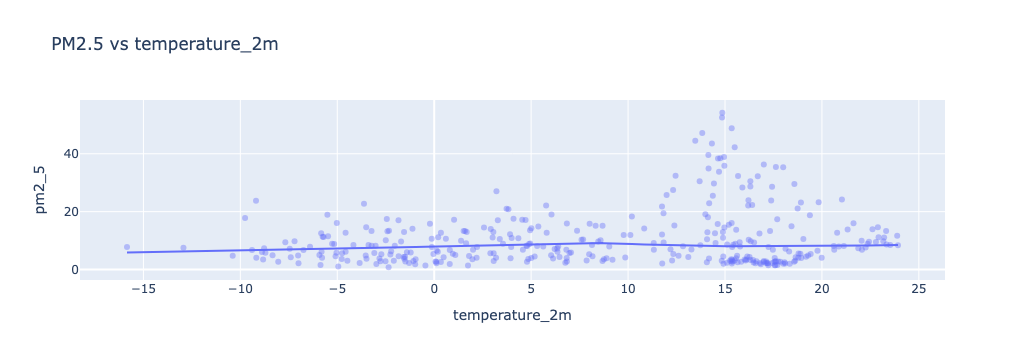

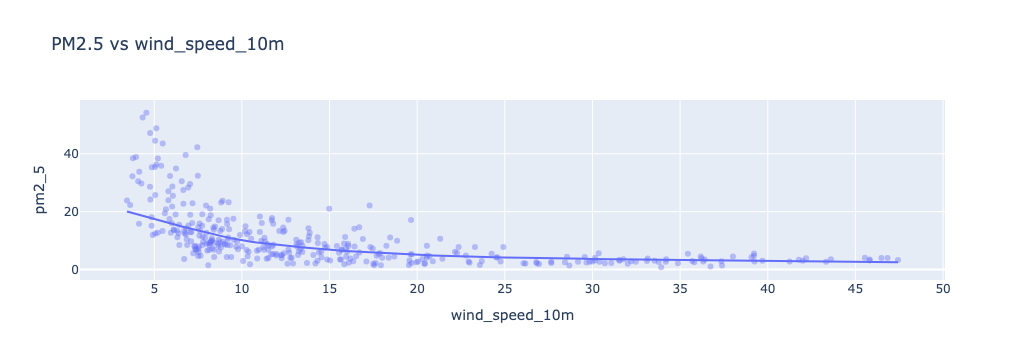

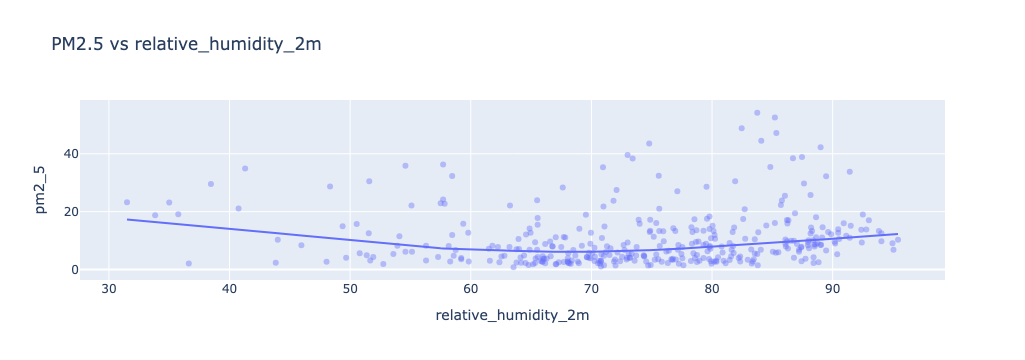

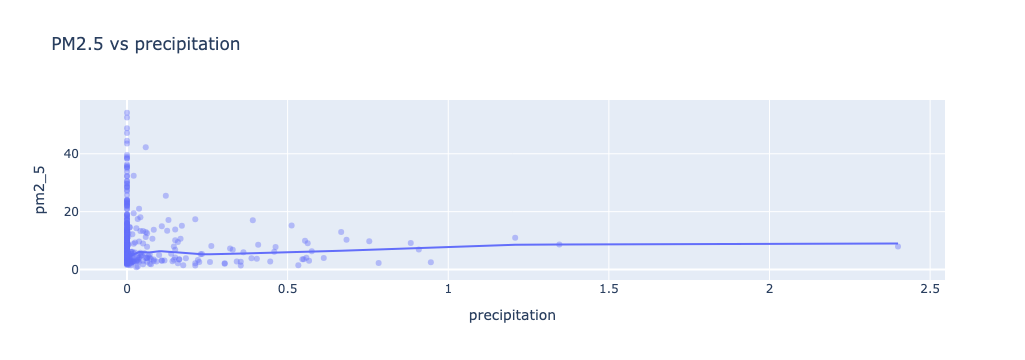

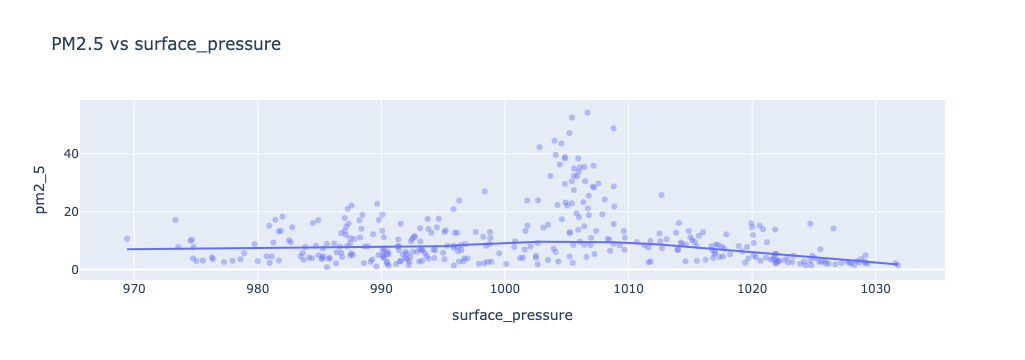

In [11]:
import plotly.express as px

weather_vars = [
    'temperature_2m',
    'wind_speed_10m',
    'relative_humidity_2m',
    'precipitation',
    'surface_pressure'
]

for var in weather_vars:
    fig = px.scatter(
        merged_df,
        x=var,
        y='pm2_5',
        opacity=0.4,
        title=f'PM2.5 vs {var}',
        trendline='lowess'
    )
    fig.show()


#### ii) Plot US AQI vs dispersion controls (Critical for Risk)
Critical to also have a look at wind speed and precipitation for dispersion aspects of weather

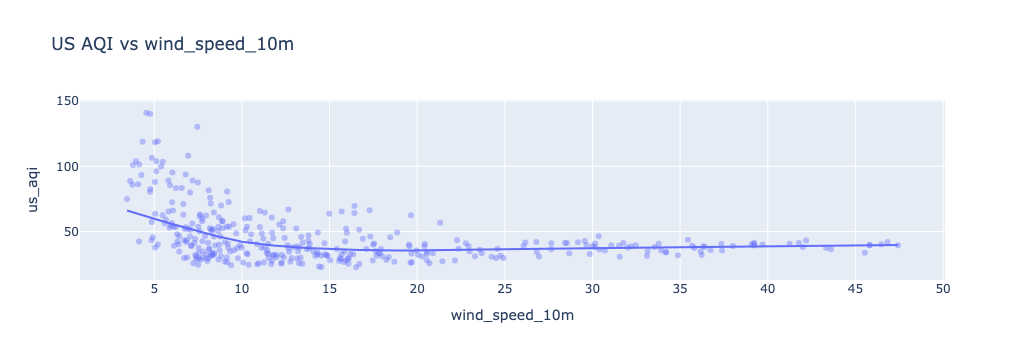

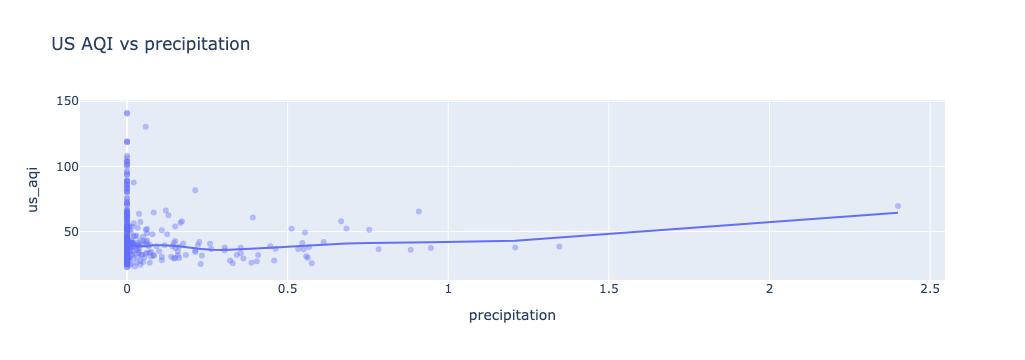

In [12]:
for var in ['wind_speed_10m', 'precipitation']:
    fig = px.scatter(
        merged_df,
        x=var,
        y='us_aqi',
        opacity=0.4,
        title=f'US AQI vs {var}',
        trendline='lowess'
    )
    fig.show()


#### Clustering Readiness Assessment

Before applying unsupervised learning, scatter plots are examined to assess whether the data exhibits structured, non-random behaviour and whether meaningful environmental regimes may exist.

#### Evidence of Non-Random Structure

Scatter plots between PM2.5, US AQI, and meteorological variables reveal clear, physically interpretable patterns. 
- PM2.5 displays a non-linear relationship with temperature, increasing up to moderate temperatures before declining at higher values. 
- Wind speed exhibits a strong dispersive effect, with pollutant concentrations peaking at low wind speeds and decreasing rapidly thereafter. 
- Relative humidity shows a monotonic increase in PM2.5, consistent with hygroscopic particle growth. 
- Precipitation demonstrates a strong threshold effect, with sharp reductions in PM2.5 following even minimal rainfall. 
- Surface pressure exhibits a non-linear pattern associated with atmospheric stability and inversion conditions.

These consistent trends indicate structured behaviour rather than random noise, satisfying a key requirement for clustering analysis. 
* Environmental data frequently violate linearity and normality assumptions; therefore, non-parametric trends are prioritised over parametric regression fits.

#### Overlapping but Separable Regimes

While the scatter plots do not show sharply bounded clusters, they exhibit dense regions, curved relationships, and threshold-driven transitions. Such overlapping but structured distributions are characteristic of environmental systems influenced by multiple interacting processes. 
- The presence of gradual regime transitions supports the use of unsupervised learning to identify dominant weather–air quality regimes without assuming strict separability.
- Based on these observations, the dataset is considered suitable for clustering to identify meaningful weather and air quality risk regimes.


## 4.3 Clustering analysis (Weather - air quality variables)
### Objective 3: Clustering Weather Regimes & Air Quality Risk Indicators
The intention is to combine meteorological and air quality variables to identify joint environmental regimes that reflect how weather conditions and pollution levels co-occur in real-world settings
#### 4.3.1 Set up for clustering.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [14]:
# Select numeric columns relevant for clustering (weather + air quality)
cluster_features = [
    'temperature_2m', 'relative_humidity_2m', 'precipitation',
    'wind_speed_10m', 'surface_pressure',
    'pm2_5', 'pm10', 'us_aqi', 'ozone',
    'nitrogen_dioxide', 'sulphur_dioxide', 'carbon_monoxide', 'carbon_dioxide'
]

# Subset the merged dataframe
df_kms = merged_df[cluster_features].copy()
df_kms.head(3)


,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,surface_pressure,pm2_5,pm10,us_aqi,ozone,nitrogen_dioxide,sulphur_dioxide,carbon_monoxide,carbon_dioxide
0,12.270667,56.291667,0.108333,15.035669,975.555111,3.087500,3.204167,27.925942,59.166667,14.420833,5.375000,214.750000,453.541667
1,8.681083,70.250000,0.029167,10.070025,979.995500,2.970833,3.008333,26.261498,59.958333,10.362500,2.295833,189.583333,447.000000
2,2.187333,73.208333,0.558333,18.010270,985.806028,4.108333,4.345833,31.056741,66.916667,6.054167,1.675000,169.041667,443.333333
3,-1.488229,68.041667,0.341667,20.051652,993.060462,2.783333,3.375000,31.962643,68.083333,5.408333,1.550000,157.000000,442.291667
4,-1.214000,72.166667,0.000000,16.706651,986.372059,5.912500,6.225000,25.040422,50.583333,14.475000,2.900000,202.125000,449.333333


### 4.3.2 ML Pipeline for Cluster
The pipeline for cluster consists of Data Cleaning (median imputation on mean smoothness), feature scaling, PCA and model (KMeans) steps.
- Select only numeric steps and drop the Date and City columns
- For now, we leave an arbitrary value of 13 (number of rows, but will be updated later) as the values of n_components of PCA and n_clusters of KMeans.
#### i) The cluster pipeline

In [15]:
from sklearn.pipeline import Pipeline

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### PCA
from sklearn.decomposition import PCA

### ML algorithm
from sklearn.cluster import KMeans

def PipelineCluster():
  pipeline_base = Pipeline([
                            
      ("scaler", StandardScaler()  ),    

      ("PCA",  PCA(n_components=13, random_state=0)), 

      ("model", KMeans(n_clusters=13, random_state=0)  ), 
  ])
  return pipeline_base

PipelineCluster()

,steps,"[('scaler', ...), ('PCA', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,13
,copy,True
,whiten,False
,svd_solver,'auto'


#### ii) determining suitable n_components for PCA 
- Create an object based on PipelineCluster(), then remove the last two steps (PCA and model): .steps[:-2]

In [16]:
# Create a new pipeline containing all steps except two, apply to transform the data 
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df_kms)

print(df_pca.shape,'\n', type(df_pca))

(360, 13) 
 <class 'numpy.ndarray'>


In [17]:
# Apply PCA separately to the scaled data
# Note: PCA implementation approach adapted from [Code Institute] Apply K-means Clustering
# Original reference: [Data Analysis and AI Bootcamp/2026]

n_components = 13 # set the number of components as all columns in the data

pca = PCA(n_components=n_components).fit(df_pca)  # set PCA object and fit to the data
x_PCA = pca.transform(df_pca) # array with transformed PCA


# the PCA object has .explained_variance_ratio_ attribute, which tells 
# how much information (variance) each component has 
# We store that to a DataFrame relating each component to its variance explanation
ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data= np.round(100 * pca.explained_variance_ratio_ ,3),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)'])

# prints how much of the dataset these components explain (naturally in this case will be 100%)
PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
print(dfExplVarRatio)

* The 13 components explain 100.0% of the data 

              Explained Variance Ratio (%)
Component 0                         55.966
Component 1                         14.729
Component 2                         10.040
Component 3                          6.439
Component 4                          5.287
Component 5                          2.377
Component 6                          1.741
Component 7                          1.245
Component 8                          0.897
Component 9                          0.691
Component 10                         0.284
Component 11                         0.216
Component 12                         0.086


- 13 components explain 100.0 % of the data
- 85%-92% is ideal for, so we pick 5 components to get slightly above 90% data variance

In [18]:
# Note: PCA implementation approach adapted from [Code Institute] Apply K-means Clustering
# Original reference: [Data Analysis and AI Bootcamp/2026]
n_components = 5

pca = PCA(n_components=n_components).fit(df_pca)
x_PCA = pca.transform(df_pca)

ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data= np.round(100 * pca.explained_variance_ratio_ ,3),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)'])

PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
print(dfExplVarRatio)

* The 5 components explain 92.46% of the data 

             Explained Variance Ratio (%)
Component 0                        55.966
Component 1                        14.729
Component 2                        10.040
Component 3                         6.439
Component 4                         5.287


In [19]:
def PipelineCluster():
  pipeline_base = Pipeline([
     
      ("scaler", StandardScaler()  ),    

      ("PCA",  PCA(n_components=5, random_state=0)),  ##### we now update the n_components to 5

      ("model", KMeans(n_clusters=13, random_state=0)  ), 
  ])
  return pipeline_base

PipelineCluster()

,steps,"[('scaler', ...), ('PCA', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,5
,copy,True
,whiten,False
,svd_solver,'auto'


#### ii) Elbow method and Silhouette score
- Prepare data by removing the last step (.steps[:-1]) and fit_transform pipeline_analysis to the data

In [20]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_kms)

print(df_analysis.shape,'\n', type(df_analysis))

(360, 5) 
 <class 'numpy.ndarray'>


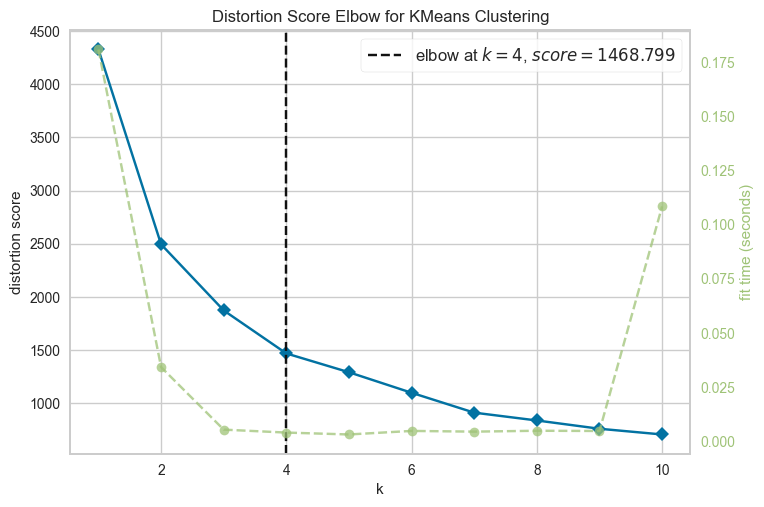

In [21]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

#### iii) Silhouette score
- This will help to interpret and validate the consistency within clusters

=== Average Silhouette Score for different number of clusters ===


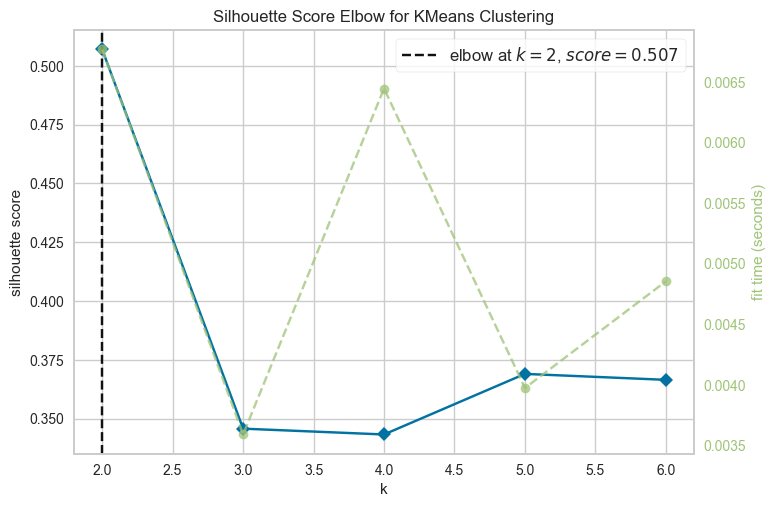



=== Silhouette plot for 2 Clusters ===


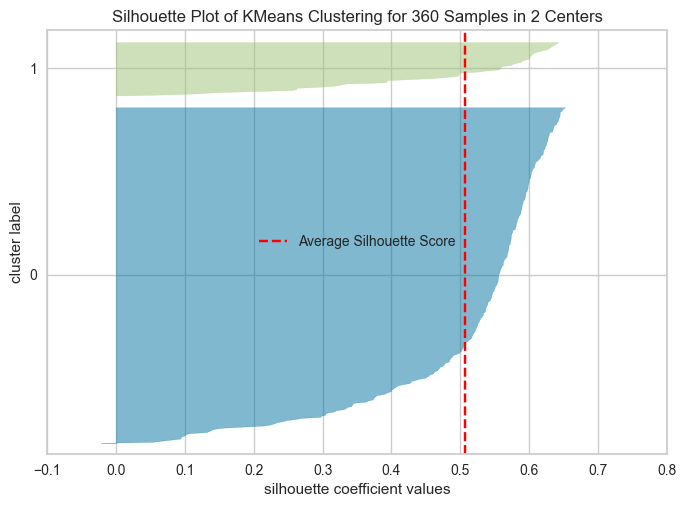



=== Silhouette plot for 3 Clusters ===


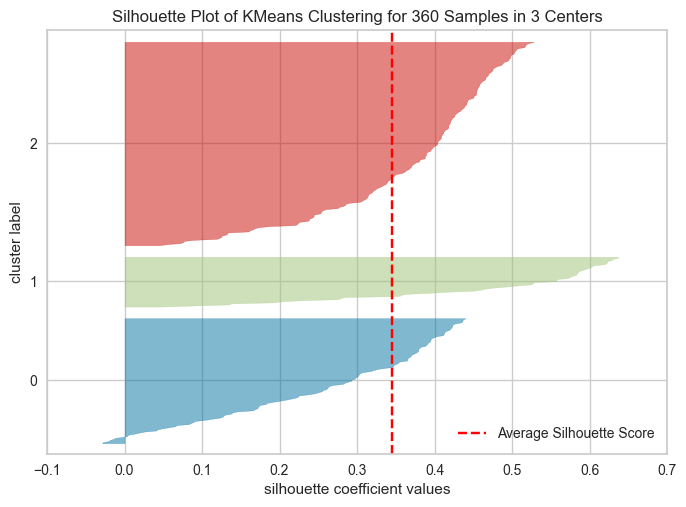



=== Silhouette plot for 4 Clusters ===


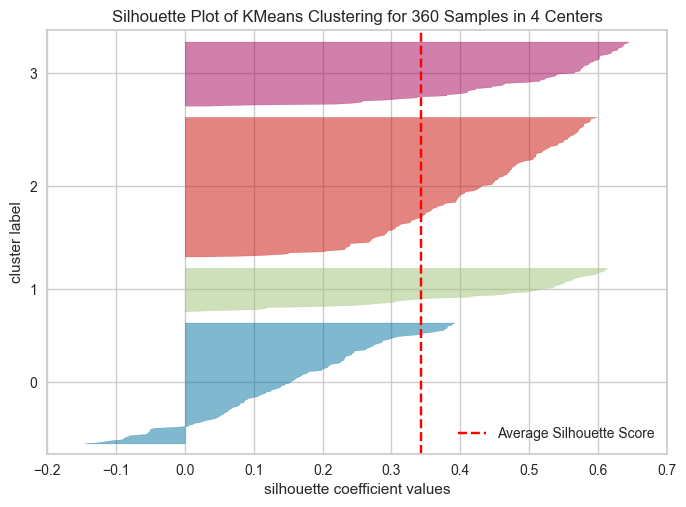



=== Silhouette plot for 5 Clusters ===


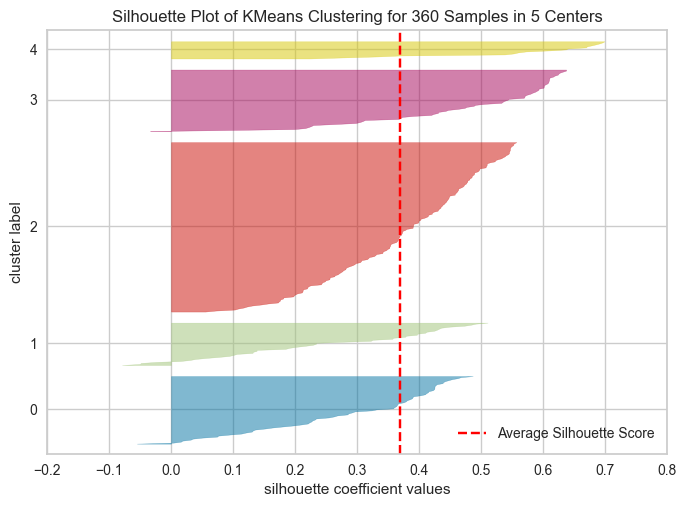



=== Silhouette plot for 6 Clusters ===


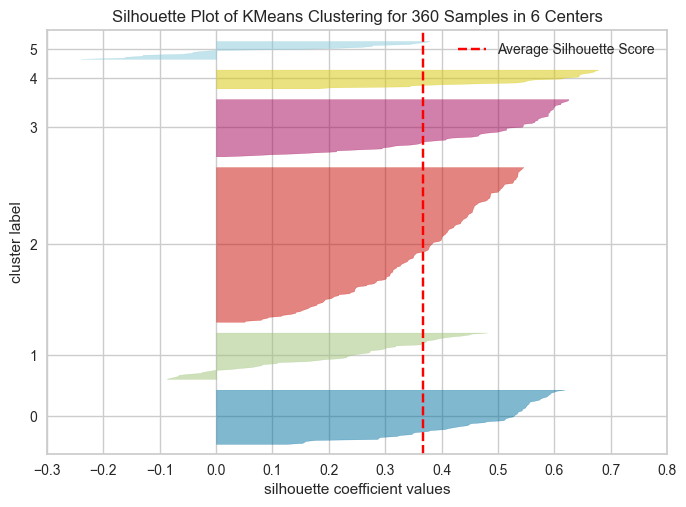



=== Silhouette plot for 7 Clusters ===


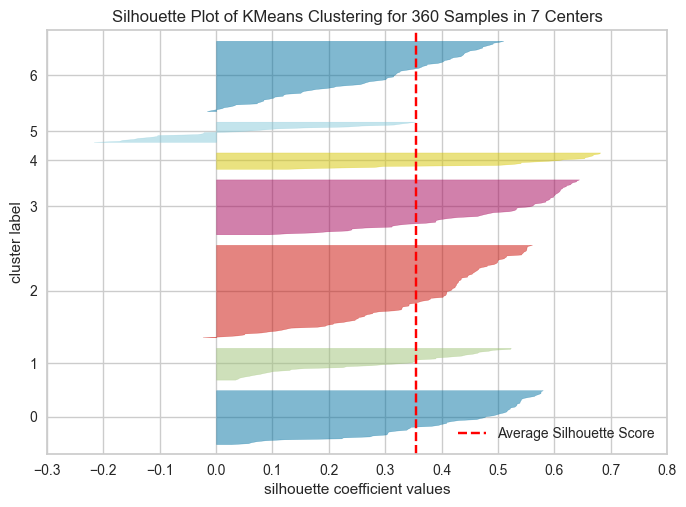



=== Silhouette plot for 8 Clusters ===


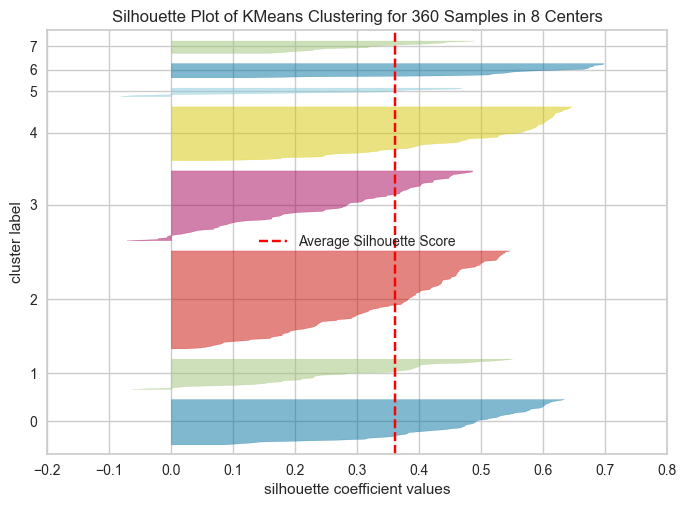



=== Silhouette plot for 9 Clusters ===


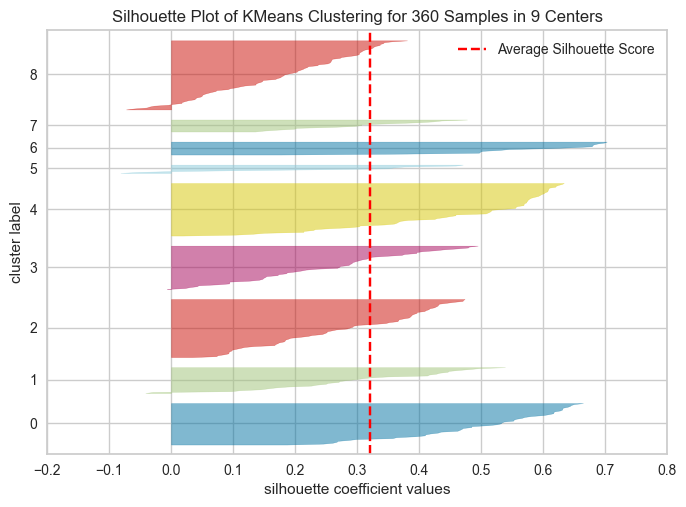



=== Silhouette plot for 10 Clusters ===


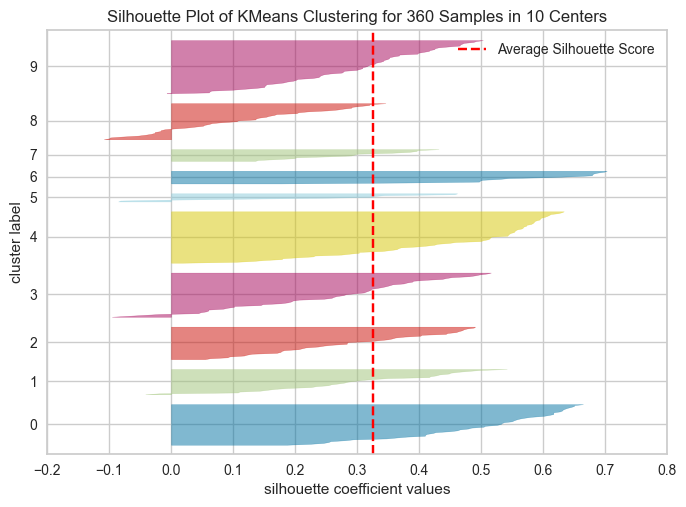

In [22]:
from yellowbrick.cluster import SilhouetteVisualizer

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(2,7), metric='silhouette')
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()
print("\n")

for n_clusters in np.arange(start=2,stop=11):
  
  print(f"=== Silhouette plot for {n_clusters} Clusters ===")
  visualizer = SilhouetteVisualizer(estimator = KMeans(n_clusters=n_clusters, random_state=0),
                                    colors = 'yellowbrick')
  visualizer.fit(df_analysis)
  visualizer.show()
  plt.show()
  print("\n")

#### iv) Selection of Number of Clusters

The number of clusters was selected using a combination of silhouette analysis and the elbow method. The elbow plot indicated diminishing returns beyond four clusters, suggesting k = 4 as a parsimonious choice.

- Silhouette plots for k = 2–5 were further examined. While higher values of k showed marginal increases in granularity, they also introduced thin or weakly populated clusters and small increases in negative silhouette values. 
- At k = 4, the majority of observations across all clusters exhibited silhouette values above the average, indicating meaningful separation with minimal overlap.

- Given the need for interpretability, stability, and alignment with environmental regime analysis, k = 4 was selected as the optimal number of clusters.
#### Next we rewrite the PipelineCluster(), updating n_cluster to 4

In [23]:
def PipelineCluster():
  pipeline_base = Pipeline([
     
      ("scaler", StandardScaler()  ),    

      ("PCA",  PCA(n_components=5, random_state=0)),  ##### we now update the n_components to 5

      ("model", KMeans(n_clusters=4, random_state=0)  ), ##### updated the n_components to 4
  ])
  return pipeline_base

PipelineCluster()

,steps,"[('scaler', ...), ('PCA', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,5
,copy,True
,whiten,False
,svd_solver,'auto'


In [24]:
#### Fit the cluster pipeline
X = df_kms.copy()
print(X.shape)
X.head(3)

(360, 13)


,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,surface_pressure,pm2_5,pm10,us_aqi,ozone,nitrogen_dioxide,sulphur_dioxide,carbon_monoxide,carbon_dioxide
0,12.270667,56.291667,0.108333,15.035669,975.555111,3.087500,3.204167,27.925942,59.166667,14.420833,5.375000,214.750000,453.541667
1,8.681083,70.250000,0.029167,10.070025,979.995500,2.970833,3.008333,26.261498,59.958333,10.362500,2.295833,189.583333,447.000000
2,2.187333,73.208333,0.558333,18.010270,985.806028,4.108333,4.345833,31.056741,66.916667,6.054167,1.675000,169.041667,443.333333


In [25]:
# fit the Cluster pipeline to the training data (X)
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

,steps,"[('scaler', ...), ('PCA', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,5
,copy,True
,whiten,False
,svd_solver,'auto'


In [26]:
# Create labels, column called Clusters
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(360, 14)


,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,surface_pressure,pm2_5,pm10,us_aqi,ozone,nitrogen_dioxide,sulphur_dioxide,carbon_monoxide,carbon_dioxide,Clusters
0,12.270667,56.291667,0.108333,15.035669,975.555111,3.087500,3.204167,27.925942,59.166667,14.420833,5.375000,214.750000,453.541667,2
1,8.681083,70.250000,0.029167,10.070025,979.995500,2.970833,3.008333,26.261498,59.958333,10.362500,2.295833,189.583333,447.000000,2
2,2.187333,73.208333,0.558333,18.010270,985.806028,4.108333,4.345833,31.056741,66.916667,6.054167,1.675000,169.041667,443.333333,2


### 4.3.3 Cluster descriptive statistics
#### - Cluster frequencies

In [30]:
# Group column Clusters by mean
cluster_profile = X.groupby('Clusters').mean()
cluster_profile


,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,surface_pressure,pm2_5,pm10,us_aqi,ozone,nitrogen_dioxide,sulphur_dioxide,carbon_monoxide,carbon_dioxide
Clusters,,,,,,,,,,,,,
0,11.120545,80.552613,0.107168,9.088560,1004.177317,12.245939,13.241879,46.835826,39.339336,26.638524,5.704696,272.069915,466.594633
1,15.713730,68.264535,0.007171,5.888456,1005.942598,31.701357,32.250000,90.623997,13.129845,61.643798,15.548643,531.462209,534.929264
2,-0.350125,69.839767,0.071201,17.164214,990.356576,5.917494,6.159620,33.923942,58.742953,13.105668,3.339430,224.801164,452.238664
3,16.837658,74.480159,0.119709,30.590247,1019.718950,3.123280,12.338294,39.171644,84.210979,0.589749,0.241005,124.909392,440.982143


* Clusters frequencies 
          proportion
Clusters            
2               0.38
0               0.33
3               0.18
1               0.12 




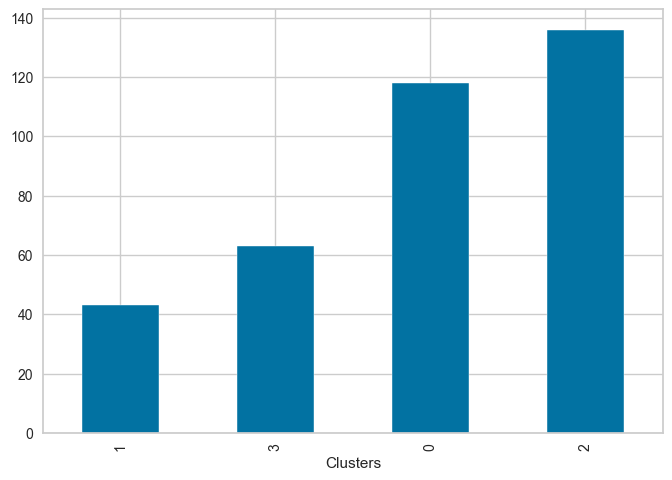

In [31]:
# Getting Cluster frequencies
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

#### Use the created label for evaluation via a classification model

In [32]:
# Get a copy 
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(360, 14)


,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,surface_pressure,pm2_5,pm10,us_aqi,ozone,nitrogen_dioxide,sulphur_dioxide,carbon_monoxide,carbon_dioxide,Clusters
0,12.270667,56.291667,0.108333,15.035669,975.555111,3.087500,3.204167,27.925942,59.166667,14.420833,5.375000,214.750000,453.541667,2
1,8.681083,70.250000,0.029167,10.070025,979.995500,2.970833,3.008333,26.261498,59.958333,10.362500,2.295833,189.583333,447.000000,2
2,2.187333,73.208333,0.558333,18.010270,985.806028,4.108333,4.345833,31.056741,66.916667,6.054167,1.675000,169.041667,443.333333,2


In [33]:
# Split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['Clusters'],axis=1),
                                    df_clf['Clusters'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(288, 13) (288,) (72, 13) (72,)


In [35]:
Create pipeline
### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithm
from sklearn.ensemble import GradientBoostingClassifier 

def PipelineClf2ExplainClusters():
  pipeline_base = Pipeline([
                            
      ("scaler", StandardScaler()  ),    

      ("feat_selection", SelectFromModel(GradientBoostingClassifier(random_state=0)) ), 

      ("model",  GradientBoostingClassifier(random_state=0) ), 
  ])
  return pipeline_base

  
PipelineClf2ExplainClusters()

,steps,"[('scaler', ...), ('feat_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,GradientBoost...andom_state=0)
,threshold,None
,prefit,False
,norm_order,1


In [36]:
# fit
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

,steps,"[('scaler', ...), ('feat_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,GradientBoost...andom_state=0)
,threshold,None
,prefit,False
,norm_order,1


#### - Metric performance via the created cluster label

In [42]:
# Train set metrics
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00        38
           2       1.00      1.00      1.00       104
           3       1.00      1.00      1.00        57

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



In [38]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        29
           1       1.00      1.00      1.00         5
           2       0.91      0.91      0.91        32
           3       1.00      1.00      1.00         6

    accuracy                           0.92        72
   macro avg       0.95      0.95      0.95        72
weighted avg       0.92      0.92      0.92        72



In [39]:
pipeline_clf_cluster

,steps,"[('scaler', ...), ('feat_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,GradientBoost...andom_state=0)
,threshold,None
,prefit,False
,norm_order,1


#### Feature Importance

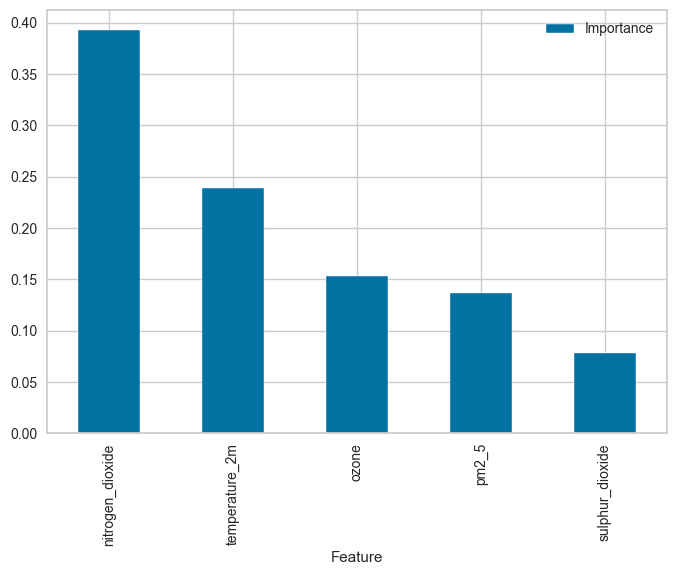

In [41]:
# If you just want the feature importance directly
df_importance = pd.DataFrame({
    'Feature': X_train.columns[pipeline_clf_cluster['feat_selection'].get_support()],
    'Importance': pipeline_clf_cluster['model'].feature_importances_
}).sort_values('Importance', ascending=False)

df_importance.plot.bar(x='Feature', y='Importance')
plt.show()

### Model Persistence
After evaluation to ensure that learned parameters are valid, reproducible, and suitable for deployment, the model is now fit for persistence. This reflects best practice in applied machine learning, where only validated models are promoted beyond the experimental stage.
- Save clusteringb model in a folder called models 

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import joblib


# Define clustering pipeline

def PipelineCluster():
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=5, random_state=0)),
        ("model", KMeans(n_clusters=4, random_state=0))
    ])
    return pipeline_base


# Train clustering model

pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)


# Assign cluster IDs to dataset

X = X.copy()
X["Cluster"] = pipeline_cluster.predict(X)


# Persist trained model

os.makedirs("models", exist_ok=True)
joblib.dump(pipeline_cluster, "../models/weather_air_regime_cluster.pkl")


['../models/weather_air_regime_cluster.pkl']

## 4.4 Prediction Modelling
### Multiclass Prediction of Engineered AQI Risk Levels
Multiclass Prediction of Engineered AQI Risk Levels